In [1]:
import numpy
from matplotlib import pyplot
import math
import random

In [2]:
C = 3e8
print(C)

300000000.0


In [3]:
def getPRI(Rmax):
    global C
    return (2*Rmax)/C

def getPRF(Rmax):
    global C
    return C/(2*Rmax)

In [4]:
# Test the above functions
print("PRI of Radar with Unambiguous range of 5 km is ", str(getPRI(5e3)*1e6), "us and PRF is ", str(getPRF(5e3)*1e-3), "KHz")
print("PRI of Radar with Unambiguous range of 50 km is ", str(getPRI(50e3)*1e6), "us and PRF is ", str(getPRF(50e3)*1e-3), "KHz")
print("PRI of Radar with Unambiguous range of 6 km is ", str(getPRI(6e3)*1e6), "us and PRF is ", str(getPRF(6e3)*1e-3), "KHz")

PRI of Radar with Unambiguous range of 5 km is  33.333333333333336 us and PRF is  30.0 KHz
PRI of Radar with Unambiguous range of 50 km is  333.3333333333333 us and PRF is  3.0 KHz
PRI of Radar with Unambiguous range of 6 km is  40.0 us and PRF is  25.0 KHz


In [5]:
# Settings
Rmax = 6e3;                          # m; Unambiguous Range of Radar
PRF = getPRF(Rmax)                   # Hz; Calculate PRF
SampleRate = 1e9                     # Hz; Sample Rate of the baseband signal
ExperimentTime=2*getPRI(Rmax);      # s; Simulation time must be multiple of PRI of Radar
N = round(ExperimentTime*SampleRate) # number of samples to generate
D = 10.0                             # %, Duty Cycle of the Pulse
PRI = 1.0/PRF                        # s; Pulse Repetition Interval
PulseHiTime = PRI*D/100.0            # s; Pulse High Time
PulseLoTime = PRI*(100.0-D)/100.0    # s; Pulse Low Time
PulseHiIndex= round(PulseHiTime*SampleRate)  # Number of index occupied by pulse high
PulseLoIndex= round(PulseLoTime*SampleRate)  # Number of index occuped by pulse low
PulseTotal  = PulseHiIndex + PulseLoIndex    # Total number of indices occupied by 1 PRI
plotDPI = 120                        # DPI of the plots
lo_f = 100e6                         # LO Frequency
lo_Prms = 0.5                        # W; LO Power
lo_A = math.sqrt(2*lo_Prms)          # LO Amplitude
lo_F = lo_f/SampleRate               # LO Digital Domain Frequency
T = 273                              # K; Operating Temperature
kB = 1.38064852e-23                  # m^2 kg s^-2; Boltzmann Constant
lo_PN = kB*T*SampleRate/2            # W; Noise Power
lo_AN = math.sqrt(2*lo_PN)           # Noise Voltage

In [6]:
print("Rmax = ",str(Rmax), " m")
print("PRF = ", str(PRF*1e-3), " KHz")
print("Sample Rate = ", str(SampleRate*1e-3), " KHz")
print("Simulation Time = ", str(ExperimentTime*1e6), " us")
print("N = ", str(N))
print("Pulse High for indices = ", str(PulseHiIndex), " per PRI")
print("Pulse Low for indices  = ", str(PulseLoIndex), " per PRI")
print("Total Pulse indices =", str(PulseTotal), "per PRI")
print("LO Frequency = ", str(lo_f*1e-6), "MHz")
print("LO Amplitude =", str(lo_A))
print("LO Digital Frequency = ", str(lo_F))
print("Operating Temperature = ", str(T), "K")
print("Noise Voltage = ", str(round(lo_AN*1e6,4)), "u")
print("Transmit SNR = ",str(round(20.0*math.log10(lo_A/lo_AN),2)), "dB")

Rmax =  6000.0  m
PRF =  25.0  KHz
Sample Rate =  1000000.0  KHz
Simulation Time =  80.0  us
N =  80000
Pulse High for indices =  4000  per PRI
Pulse Low for indices  =  36000  per PRI
Total Pulse indices = 40000 per PRI
LO Frequency =  100.0 MHz
LO Amplitude = 1.0
LO Digital Frequency =  0.1
Operating Temperature =  273 K
Noise Voltage =  1.9414 u
Transmit SNR =  114.24 dB


In [7]:
index = numpy.linspace(0,N,N+1)

In [8]:
# Generate the baseband pulse 
lsamples = list()
for k in index:
    k1 = k % PulseTotal
    if k1<PulseHiIndex:
        lsamples.append(complex(1.0, 0.0))
    else:
        lsamples.append(complex(0.0, 0.0))

IQ = numpy.array(lsamples)


(-0.05, 1.05)

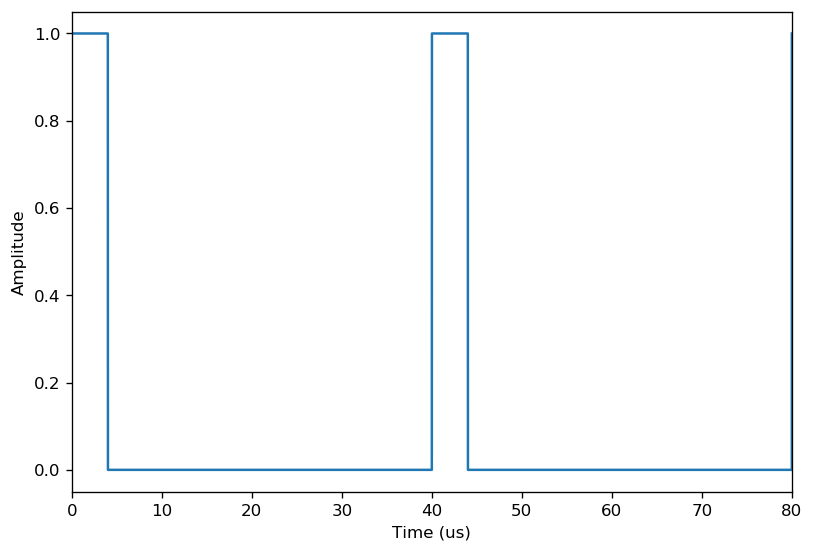

In [9]:
# Plot the baseband samples
timeIndex = index * (1.0/SampleRate) * 1.0e6

fig = pyplot.figure(dpi=plotDPI)
ax = fig.add_axes([0,0,1,1])
ax.plot(timeIndex, IQ.real, label="real")
#ax.plot(timeIndex, IQ.imag, label="imag")

#ax.legend()

ax.set_xlabel("Time (us)")
ax.set_ylabel("Amplitude")

ax.set_xlim([0, (N/SampleRate*1.0e6)])
ax.set_ylim([-0.05, 1.05])

In [10]:
# Generate the LO Sine Wave to modulate the pulse
lo_phases = [(2*numpy.pi*lo_F*index1) for index1 in index]
lo_iq = [complex(math.cos(phase1), math.sin(phase1)) for phase1 in lo_phases]
lo_IQ = numpy.array(lo_iq)

(-1.05, 1.05)

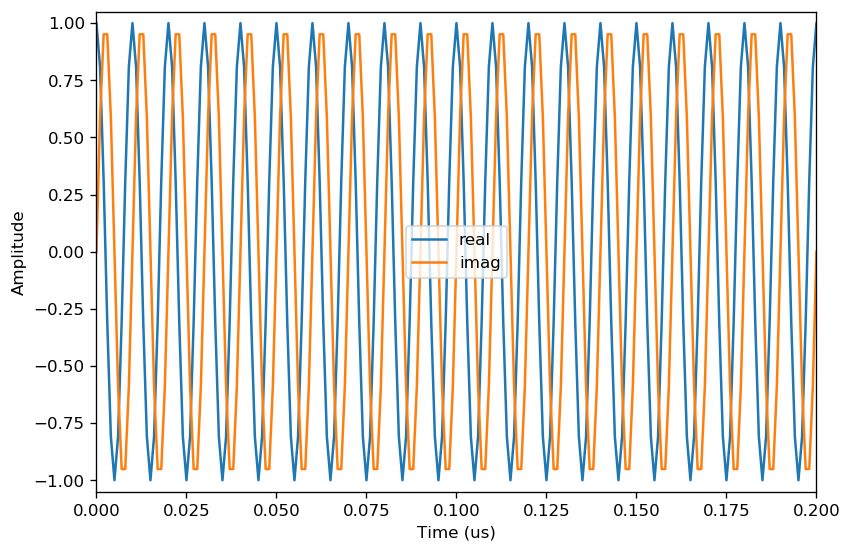

In [11]:
# Plot this Sine Wave
fig = pyplot.figure(dpi=plotDPI)
ax = fig.add_axes([0,0,1,1])
ax.plot(timeIndex, lo_IQ.real, label="real")
ax.plot(timeIndex, lo_IQ.imag, label="imag")

ax.legend()

ax.set_xlabel("Time (us)")
ax.set_ylabel("Amplitude")

ax.set_xlim([0, (min(200,N)/SampleRate*1.0e6)])
ax.set_ylim([-1.05, 1.05])

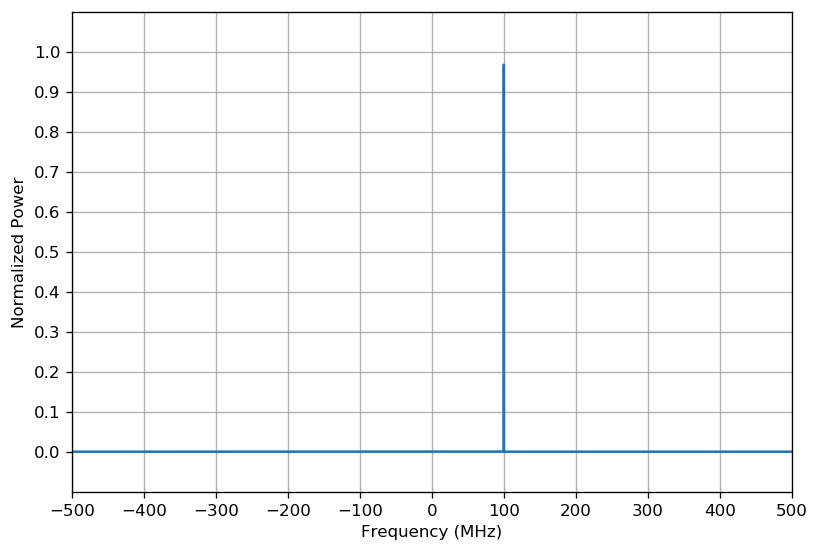

In [12]:
# Plot the Frequency Domain Plot
freqPower = numpy.fft.fft(lo_IQ)
freqPower = numpy.fft.fftshift(freqPower)
freqPower = numpy.power(numpy.absolute(freqPower),2)
freqPowerSum = numpy.sum(freqPower)
freqPower = freqPower/freqPowerSum

freqIndex = (index*SampleRate/N) - SampleRate/2
freqIndex *= 10**-6

fig= pyplot.figure(dpi = plotDPI)
ax = fig.add_axes([0,0,1,1])
ax.plot(freqIndex, freqPower.real)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Normalized Power")
ax.grid(True)
ax.set_xlim(-SampleRate/2*10**-6, +SampleRate/2*10**-6)
ax.set_ylim([-0.1,1.1])
ax.set_xticks(numpy.linspace(-SampleRate/2*10**-6, +SampleRate/2*10**-6, 11));
ax.set_yticks(numpy.linspace(0, 1, 11));

In [13]:
# Modulate the Radar Pulse with the Sine Wave
mod_IQ = numpy.multiply(IQ, lo_IQ)

In [14]:
# Add thermal Noise
thermnoise_iq = [complex(random.uniform(-lo_AN/2,lo_AN/2),random.uniform(-lo_AN/2,lo_AN/2)) for _ in index]
thermnoise_IQ = numpy.array(thermnoise_iq)
mod_IQ = numpy.add(mod_IQ, thermnoise_IQ)

(-1.05, 1.05)

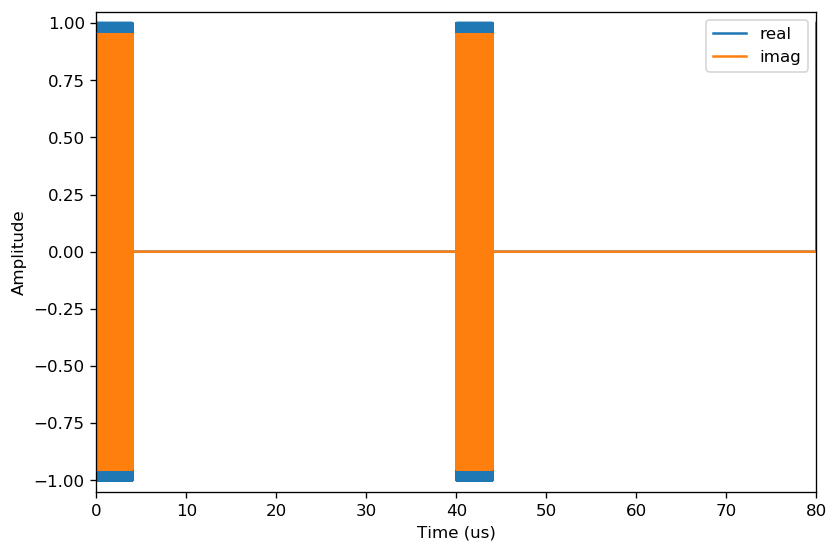

In [15]:
# Plot the time domain of the modulated pulse
fig = pyplot.figure(dpi=plotDPI)
ax = fig.add_axes([0,0,1,1])
ax.plot(timeIndex, mod_IQ.real, label="real")
ax.plot(timeIndex, mod_IQ.imag, label="imag")

ax.legend()

ax.set_xlabel("Time (us)")
ax.set_ylabel("Amplitude")

ax.set_xlim([0, (N/SampleRate*1.0e6)])
ax.set_ylim([-1.05, 1.05])

(-0.02, 0.12)

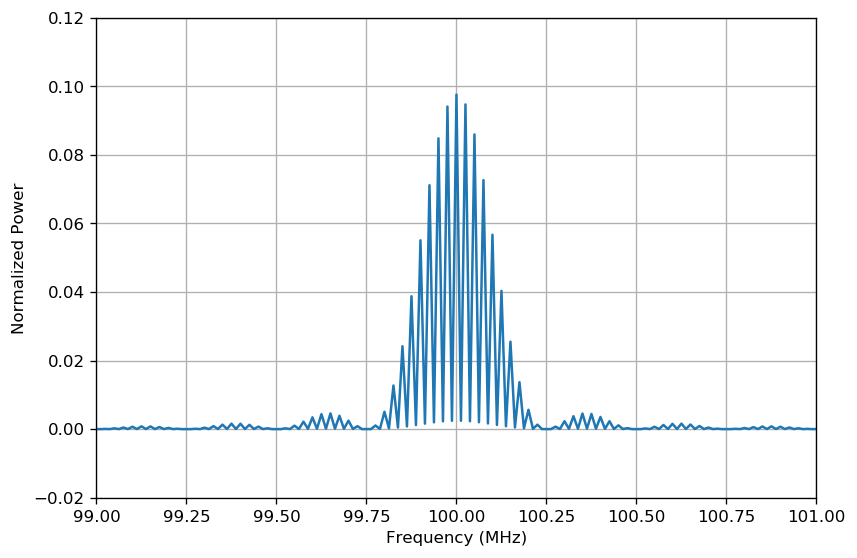

In [16]:
# Plot the Frequency Domain Plot
freqPower = numpy.fft.fft(mod_IQ)
freqPower = numpy.fft.fftshift(freqPower)
freqPower = numpy.power(numpy.absolute(freqPower),2)
freqPowerSum = numpy.sum(freqPower)
freqPower = freqPower/freqPowerSum

freqIndex = (index*SampleRate/N) - SampleRate/2
freqIndex *= 10**-6

fig= pyplot.figure(dpi = plotDPI)
ax = fig.add_axes([0,0,1,1])
ax.plot(freqIndex, freqPower.real)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Normalized Power")
ax.grid(True)
ax.set_xlim(99,101)
#ax.set_xlim(-SampleRate/2*10**-6, +SampleRate/2*10**-6)
ax.set_ylim([-0.02,0.12])
#ax.set_xticks(numpy.linspace(-SampleRate/2*10**-6, +SampleRate/2*10**-6, 11));
#ax.set_yticks(numpy.linspace(0, 1, 11));